# Agent-Based Dynamic Slot Filling

- Author: [Jongcheol Kim](https://github.com/greencode-99)
- Design: 
- Peer Review: [kofsitho87](https://github.com/kofsitho87), [Heeah Kim](https://github.com/yellowGangneng) 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/17-Agent-BasedDynamicSlotFilling.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/17-Agent-BasedDynamicSlotFilling.ipynb)

## Overview

이 노트북은 LangGraph를 사용하여 레스토랑 예약을 위한 슬롯 필링 시스템을 구현합니다.

### Table of Contents

- [Overview](#overview)


### References

- [LangChain: Query Construction](https://blog.langchain.dev/query-construction/)
- [LangGraph: Self-Reflective RAG](https://blog.langchain.dev/agentic-rag-with-langgraph/)
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
!pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain_openai",
        "langgraph",
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Agent-Based-Dynamic-Slot-Filling",  # title 과 동일하게 설정해 주세요
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## 참고 (이미지 파일명 관련)


In [5]:
# 필요한 라이브러리 임포트
from typing import Dict, TypedDict, List, Tuple, Optional
from datetime import datetime
import json

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolExecutor

## State 정의
TypedDict를 상속받아 대화 에이전트의 상태를 정의하는 클래스입니다.

In [33]:
# 상태 정의
class State(TypedDict):
    messages: List[str]
    slots: Dict[str, str]
    current_slot: Optional[str]
    completed: bool

## SLOT_EXTRACTION_TEMPLATE
대화에서 레스토랑 예약 정보를 추출하기 위한 프롬프트 템플릿입니다.

In [34]:
# 슬롯 추출 프롬프트 템플릿
SLOT_EXTRACTION_TEMPLATE = """다음 대화에서 레스토랑 예약과 관련된 정보를 추출해주세요.
필요한 정보:
- restaurant_address: 레스토랑 주소/위치 (도시명만)
- number_of_people: 인원 수 (숫자만)
- reservation_datetime: 예약 일시 (YYYY/MM/DD HH:MM 형식)

현재 슬롯 상태:
{slots}

대화:
{messages}

마지막 메시지:
{last_message}

JSON 형식으로 응답해주세요."""

slot_extraction_prompt = ChatPromptTemplate.from_template(SLOT_EXTRACTION_TEMPLATE)

## RESPONSE_TEMPLATE
대화형 에이전트가 사용자와 자연스러운 대화를 통해 누락된 예약 정보를 수집하기 위한 프롬프트 템플릿입니다.

In [35]:
# 응답 생성 프롬프트 템플릿
RESPONSE_TEMPLATE = """친근한 톤으로 대화를 이어가며 누락된 정보를 수집하세요.

현재 슬롯 상태:
{slots}

대화 기록:
{messages}

다음 규칙을 따르세요:
1. restaurant_address가 null이면 위치를 물어보세요
2. number_of_people이 null이면 인원 수를 물어보세요
3. reservation_datetime이 null이면 예약 시간을 물어보세요
4. 모든 정보가 수집되면 'Finish[yes]'를 출력하세요

자연스러운 대화체로 응답하세요."""

response_prompt = ChatPromptTemplate.from_template(RESPONSE_TEMPLATE)

## 슬롯 추출 및 응답 생성 함수 정의
- extract_slots 
    - 대화에서 예약 관련 정보를 추출하는 함수입니다.
- generate_response 
    - 사용자와의 대화를 위한 응답을 생성하는 함수입니다.

In [41]:
def extract_slots(state: State) -> State:
    llm = ChatOpenAI(temperature=0)

    last_message = state["messages"][-1] if state["messages"] else ""
    chain = slot_extraction_prompt | llm

    result = chain.invoke(
        {
            "slots": json.dumps(state["slots"], ensure_ascii=False),
            "messages": "\n".join(state["messages"]),
            "last_message": last_message,
        }
    )

    new_slots = json.loads(result.content)
    state["slots"].update(new_slots)

    return state

In [42]:
def generate_response(state: State) -> State:
    llm = ChatOpenAI(temperature=0.7)
    chain = response_prompt | llm

    result = chain.invoke(
        {
            "slots": json.dumps(state["slots"], ensure_ascii=False),
            "messages": "\n".join(state["messages"]),
        }
    )

    response = result.content
    state["messages"].append(response)

    # 모든 슬롯이 유효한 값으로 채워졌는지 확인
    required_fields = {
        "restaurant_address": state["slots"]["restaurant_address"],
        "number_of_people": state["slots"]["number_of_people"],
        "reservation_datetime": state["slots"]["reservation_datetime"],
    }

    # 모든 필수 필드가 유효한 값을 가지고 있는지 확인
    all_slots_filled = all(
        value is not None
        and value != "null"
        and value.strip() != ""
        and value != "undefined"
        for value in required_fields.values()
    )

    # 모든 슬롯이 채워졌다면 완료 처리
    if all_slots_filled:
        state["completed"] = True
        response = (
            f"예약이 완료되었습니다!\n"
            f"위치: {state['slots']['restaurant_address']}\n"
            f"인원: {state['slots']['number_of_people']}명\n"
            f"일시: {state['slots']['reservation_datetime']}"
        )
        state["messages"].append(response)

    return state

## Graph 생성
그래프를 생성하고 노드와 엣지를 추가합니다.

In [43]:
# 그래프 생성
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("extract_slots", extract_slots)
workflow.add_node("generate_response", generate_response)

workflow.add_edge(START, "extract_slots")

# 나머지 엣지 연결
workflow.add_edge("extract_slots", "generate_response")
workflow.add_edge("generate_response", END)

# 그래프 컴파일
app = workflow.compile()

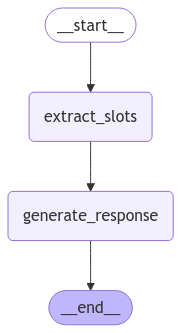

In [38]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# Visualize the compiled StateGraph as a Mermaid diagram
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Example
예약 시스템 실행

In [44]:
def chat():
    # 초기 상태
    initial_state = {
        "messages": [],
        "slots": {
            "restaurant_address": "null",
            "number_of_people": "null",
            "reservation_datetime": "null",
        },
        "current_slot": None,
        "completed": False,
    }
    state = initial_state.copy()

    print("\n=== 레스토랑 예약 시스템 ===")
    print("챗봇: 안녕하세요! 레스토랑 예약을 도와드리겠습니다.")
    print("종료하시려면 'exit'를 입력해주세요.\n")

    while True:
        user_input = input("\n사용자: ")
        if user_input.lower() == "exit":
            print("\n예약 시스템을 종료합니다.")
            break

        state["messages"].append(user_input)
        new_state = app.invoke(state)
        print(new_state)
        print(f"\n챗봇: {new_state['messages'][-1]}")
        print(f"\n현재 수집된 정보:")
        for slot, value in new_state["slots"].items():
            print(f"- {slot}: {value}")

        if new_state["completed"]:
            print("\n모든 정보가 수집되었습니다. 예약이 완료되었습니다!")
            break

        state = new_state


chat()


=== 레스토랑 예약 시스템 ===
챗봇: 안녕하세요! 레스토랑 예약을 도와드리겠습니다.
종료하시려면 'exit'를 입력해주세요.

{'messages': ['내일 저녁 식사 예약해줘', '안녕하세요! 내일 저녁 식사 예약을 도와드릴게요. 먼저, 식사를 예약할 식당의 위치가 어디인지 알려주시겠어요?'], 'slots': {'restaurant_address': 'null', 'number_of_people': 'null', 'reservation_datetime': '2023/03/15 19:00'}, 'current_slot': None, 'completed': False}

챗봇: 안녕하세요! 내일 저녁 식사 예약을 도와드릴게요. 먼저, 식사를 예약할 식당의 위치가 어디인지 알려주시겠어요?

현재 수집된 정보:
- restaurant_address: null
- number_of_people: null
- reservation_datetime: 2023/03/15 19:00
{'messages': ['내일 저녁 식사 예약해줘', '안녕하세요! 내일 저녁 식사 예약을 도와드릴게요. 먼저, 식사를 예약할 식당의 위치가 어디인지 알려주시겠어요?', '경기도 성남', '식당 위치는 이미 알고 있네요. 그럼 예약하실 분들은 몇 명이신가요?'], 'slots': {'restaurant_address': '성남', 'number_of_people': 'null', 'reservation_datetime': '2023/03/15 19:00'}, 'current_slot': None, 'completed': False}

챗봇: 식당 위치는 이미 알고 있네요. 그럼 예약하실 분들은 몇 명이신가요?

현재 수집된 정보:
- restaurant_address: 성남
- number_of_people: null
- reservation_datetime: 2023/03/15 19:00
{'messages': ['내일 저녁 식사 예약해줘', '안녕하세요! 내일 저녁 식사 예약을 